In [241]:
import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml

### read configs

In [247]:
with open('./config/config.yml', encoding='utf-8') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)


### prepare data

In [3]:
adata = sc.read_h5ad("/ictstr01/groups/ml01/workspace/shrey.parikh/PDAC_Work_Dir/PDAC_Final/Human_Atlas_Harmonised_genes_filtered.h5ad")

In [5]:
dict_radio = {'Chemotherapy': 'No Radiotherapy', 
              'Untreated': 'Untreated', 
              'Chemotherapy + Radiotherapy': 'Radiotherapy', 
              'Other': 'No Radiotherapy', 'Chemotherapy + Radiotherapy + Immunotherapy': 'Radiotherapy', 
              'Unknown': 'Unknown'}

In [4]:
adata.obs['Malignant_epi'] = ['Malignant' if 'Malignant Cell - E' in cell else 'Non Malignant' for cell in adata.obs.Level_3]
adata.obs['Malignant_mes'] = ['Malignant' if 'Mesenchymal' in cell else 'Non Malignant' for cell in adata.obs.Level_3]

In [5]:
adata_malignant = adata[adata.obs.Level_3.str.contains('Malignant')].copy()

In [6]:
adata.obs['Radiotherapy_Status']= adata.obs.TreatmentType.map(dict_radio)

In [7]:
adata_filt = adata[adata.obs.Radiotherapy_Status.isin(['Radiotherapy', 'No Radiotherapy', 'Untreated'])].copy()

In [8]:
adata_malignant = adata_filt[adata_filt.obs.Level_3.str.contains('Malignant')].copy()

# Stratification

## Radiotherapy barplot

In [116]:
ps_adata_all_cells_bulk = sc.read_h5ad('ps_adata_all_cells_bulk.h5ad')

In [117]:
ps_adata_all_cells_bulk.obs['Radiotherapy_Status']= ps_adata_all_cells_bulk.obs.TreatmentType.map(dict_radio)

In [159]:
ps_adata_all_cells_bulk = ps_adata_all_cells_bulk[ps_adata_all_cells_bulk.obs.Radiotherapy_Status != 'Unknown'].copy()

In [133]:
ps_adata_all_cells_bulk.obsm['x_diff'] = ps_adata_all_cells_bulk.obsm['X_diffmap'] 
del ps_adata_all_cells_bulk.obsm['X_diffmap']

In [165]:
mapping = {
    'Epi-High': '1',
    'Acinar-Like': '1',
    'Hypoxia/Senescence-High': '2',
    'EMT-Start': '3',
    'Tip':'4',
    'Mes-High':'5'
}
ps_adata_all_cells_bulk.obs['leiden_cell_comp'] = ps_adata_all_cells_bulk.obs['Cluster_Names'].map(mapping)

In [257]:
mkdir fig4

/home/icb/daniele.lucarelli/miniconda3/envs/notebooks/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/daniele.lucarelli/miniconda3/envs/notebooks/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


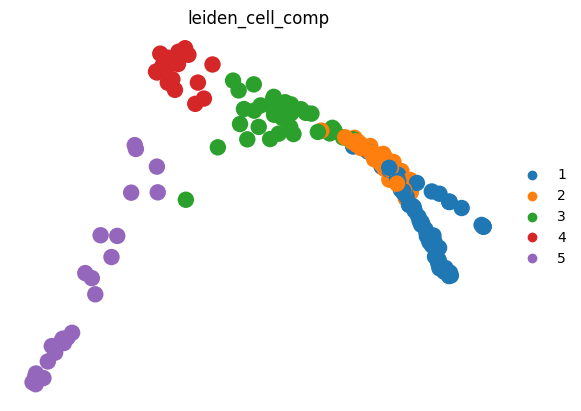

In [258]:
sc.pl.embedding(ps_adata_all_cells_bulk, basis = "X_diffmap_2_4", color = "leiden_cell_comp", frameon=False,  show = False)
plt.savefig('./fig4/trajectory_patient_leiden.pdf', dpi = 300, bbox_inches='tight')

/tmp/ipykernel_768192/1061842842.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_counts = data.groupby(['Radiotherapy_Status', 'leiden_cell_comp']).size().reset_index(name='Count')
/tmp/ipykernel_768192/1061842842.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = freq_counts.groupby('Radiotherapy_Status')['Count'].transform('sum')
/tmp/ipykernel_768192/1061842842.py:11: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  barplot = sns.barplot(


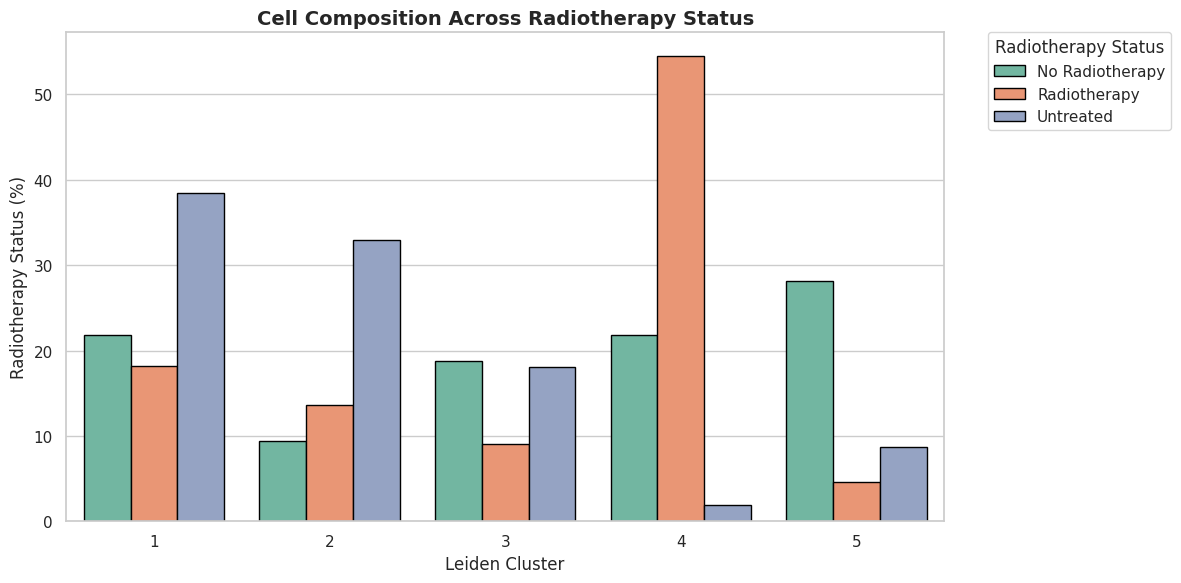

In [265]:
data = ps_adata_all_cells_bulk.obs.copy()
freq_counts = data.groupby(['Radiotherapy_Status', 'leiden_cell_comp']).size().reset_index(name='Count')

total_counts = freq_counts.groupby('Radiotherapy_Status')['Count'].transform('sum')

freq_counts['Percentage'] = 100 * freq_counts['Count'] / total_counts

sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
palette = sns.color_palette('Set2')
barplot = sns.barplot(
    data=freq_counts,
    x='leiden_cell_comp',
    y='Percentage',
    hue='Radiotherapy_Status',
    palette=palette,
    edgecolor='black'
)
plt.xticks(rotation=0, ha='center')
plt.xlabel('Leiden Cluster', fontsize=12)
plt.ylabel('Radiotherapy Status (%)', fontsize=12)
plt.title('Cell Composition Across Radiotherapy Status', fontsize=14, weight='bold')

plt.legend(
    title='Radiotherapy Status',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0
)

# Tidy layout
plt.tight_layout()
plt.savefig('./fig4/barplot_radiotherapy_status_bulk_patients.pdf', dpi = 300, bbox_inches='tight')

## drvi

In [4]:
import drvi
from drvi.model import DRVI
from drvi.utils.misc import hvg_batch

/home/icb/daniele.lucarelli/miniconda3/envs/notebooks/lib/python3.12/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/icb/daniele.lucarelli/miniconda3/envs/notebooks/lib/python3.12/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/icb/daniele.lucarelli/miniconda3/envs/notebooks/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
sc.pp.highly_variable_genes(adata_malignant, batch_key='Radiotherapy_Status', n_top_genes=8000, layer='log_norm')

/home/icb/daniele.lucarelli/miniconda3/envs/notebooks/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/icb/daniele.lucarelli/miniconda3/envs/notebooks/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/icb/daniele.lucarelli/miniconda3/envs/notebooks/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning

In [31]:
adata_malignant.var.highly_variable_intersection.value_counts()

highly_variable_intersection
False    36706
True      2335
Name: count, dtype: int64

In [32]:
adata_malignant_hvg = adata_malignant[:, adata_malignant.var.highly_variable_intersection].copy()

In [35]:
DRVI.setup_anndata(
    adata_malignant_hvg,
    layer="counts",
    categorical_covariate_keys=["Dataset_ID"],
    is_count_data=True,
)

# construct the model
model = DRVI(
    adata_malignant_hvg,
    categorical_covariates=["Dataset_ID"],
    n_latent=64,
    encoder_dims=[64, 64],
    decoder_dims=[64, 64],
)
model

INFO     DRVI: The model has been initialized                                                                      


/home/icb/daniele.lucarelli/miniconda3/envs/notebooks/lib/python3.12/site-packages/drvi/scvi_tools_based/data/fields/_fixed_fields.py:29: UserWarning: Category 96 in adata.obs['Dataset_ID'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(df, key, key, categorical_dtype=categorical_dtype)


DRVI 
Covariates: ['Dataset_ID'], 
Latent size: 64, splits: 64, pooling of splits: 'logsumexp', 
Encoder dims: [64, 64], 
Decoder dims: [64, 64], 
Gene likelihood: pnb_softmax, 

Training status: Not Trained
Model's adata is minified?: False

In [36]:
n_epochs = 100

# train the model
model.train(
    max_epochs=n_epochs,
    early_stopping=False,
    early_stopping_patience=20,
    plan_kwargs={
        "n_epochs_kl_warmup": n_epochs,
    },
)


/home/icb/daniele.lucarelli/miniconda3/envs/notebooks/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.1 /home/icb/daniele.lucarelli/miniconda3/envs/noteb ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/daniele.lucarelli/miniconda3/envs/notebooks/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.1 /home/icb/daniele.lucarelli/miniconda3/envs/noteb ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE

Epoch 100/100: 100%|█| 100/100 [32:41<00:00, 19.47s/it, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|█| 100/100 [32:41<00:00, 19.61s/it, v_num=1, train_loss_step


In [37]:
model.save("./drvi", overwrite=True)
model = DRVI.load("./drvi", adata_malignant_hvg)

INFO     File ./drvi/model.pt already downloaded                                                                   


/home/icb/daniele.lucarelli/miniconda3/envs/notebooks/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.1 /home/icb/daniele.lucarelli/miniconda3/envs/noteb ...
  rank_zero_warn(


INFO     DRVI: The model has been initialized                                                                      


/home/icb/daniele.lucarelli/miniconda3/envs/notebooks/lib/python3.12/site-packages/drvi/scvi_tools_based/data/fields/_fixed_fields.py:29: UserWarning: Category 96 in adata.obs['Dataset_ID'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(df, key, key, categorical_dtype=categorical_dtype)


In [38]:
adata_malignant_hvg.obsm['X_drVI'] = model.get_latent_representation()

In [48]:
import anndata as ad
embed = ad.AnnData(model.get_latent_representation(), obs=adata_malignant_hvg.obs, obsm=adata_malignant_hvg.obsm, obsp=adata_malignant_hvg.obsp,uns=adata_malignant_hvg.uns)


In [49]:
#sc.pp.neighbors(embed, n_neighbors=10, use_rep="X", n_pcs=embed.X.shape[1])
sc.tl.umap(embed, spread=1.0, min_dist=0.5, random_state=123)


In [273]:
config['plot_configs'].keys()

dict_keys(['general', 'embeddings_plots', 'continuous_plots', 'rank_genes_plots'])

/home/icb/daniele.lucarelli/miniconda3/envs/notebooks/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/daniele.lucarelli/miniconda3/envs/notebooks/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/icb/daniele.lucarelli/miniconda3/envs/notebooks/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/icb/daniele.lucarelli/miniconda3/envs/notebooks/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots

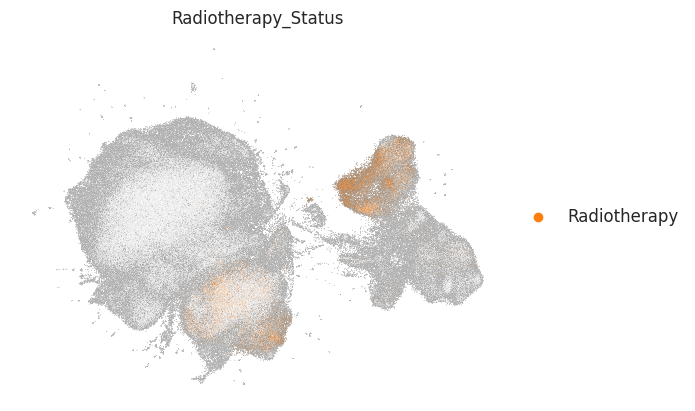

In [278]:
sc.pl.umap(embed, color=["Radiotherapy_Status"], groups='Radiotherapy', **config['plot_configs']['embeddings_plots'], show = False)
plt.savefig('./fig4/umap_radiotherapyh_highlight.pdf', dpi = 300, bbox_inches='tight')

In [52]:
drvi.utils.tl.set_latent_dimension_stats(model, embed)

/home/icb/daniele.lucarelli/miniconda3/envs/notebooks/lib/python3.12/site-packages/drvi/utils/tools/_latent.py:68: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  embed.var["reconstruction_effect"].loc[embed.var.sort_values("original_dim_id").

In [281]:
config['plot_configs']['embeddings_plots']

{'alpha': 0.75,
 'frameon': False,
 'add_outline': True,
 'layer': 'log_norm',
 'legend_fontsize': 12,
 'outline_color': ['black', 'white'],
 'outline_width': [0.2, 0.025],
 'ncols': 1,
 'vmax': 'p98',
 'cmap': 'viridis',
 'na_color': 'white',
 'na_in_legend': False}

/home/icb/daniele.lucarelli/miniconda3/envs/notebooks/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/home/icb/daniele.lucarelli/miniconda3/envs/notebooks/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


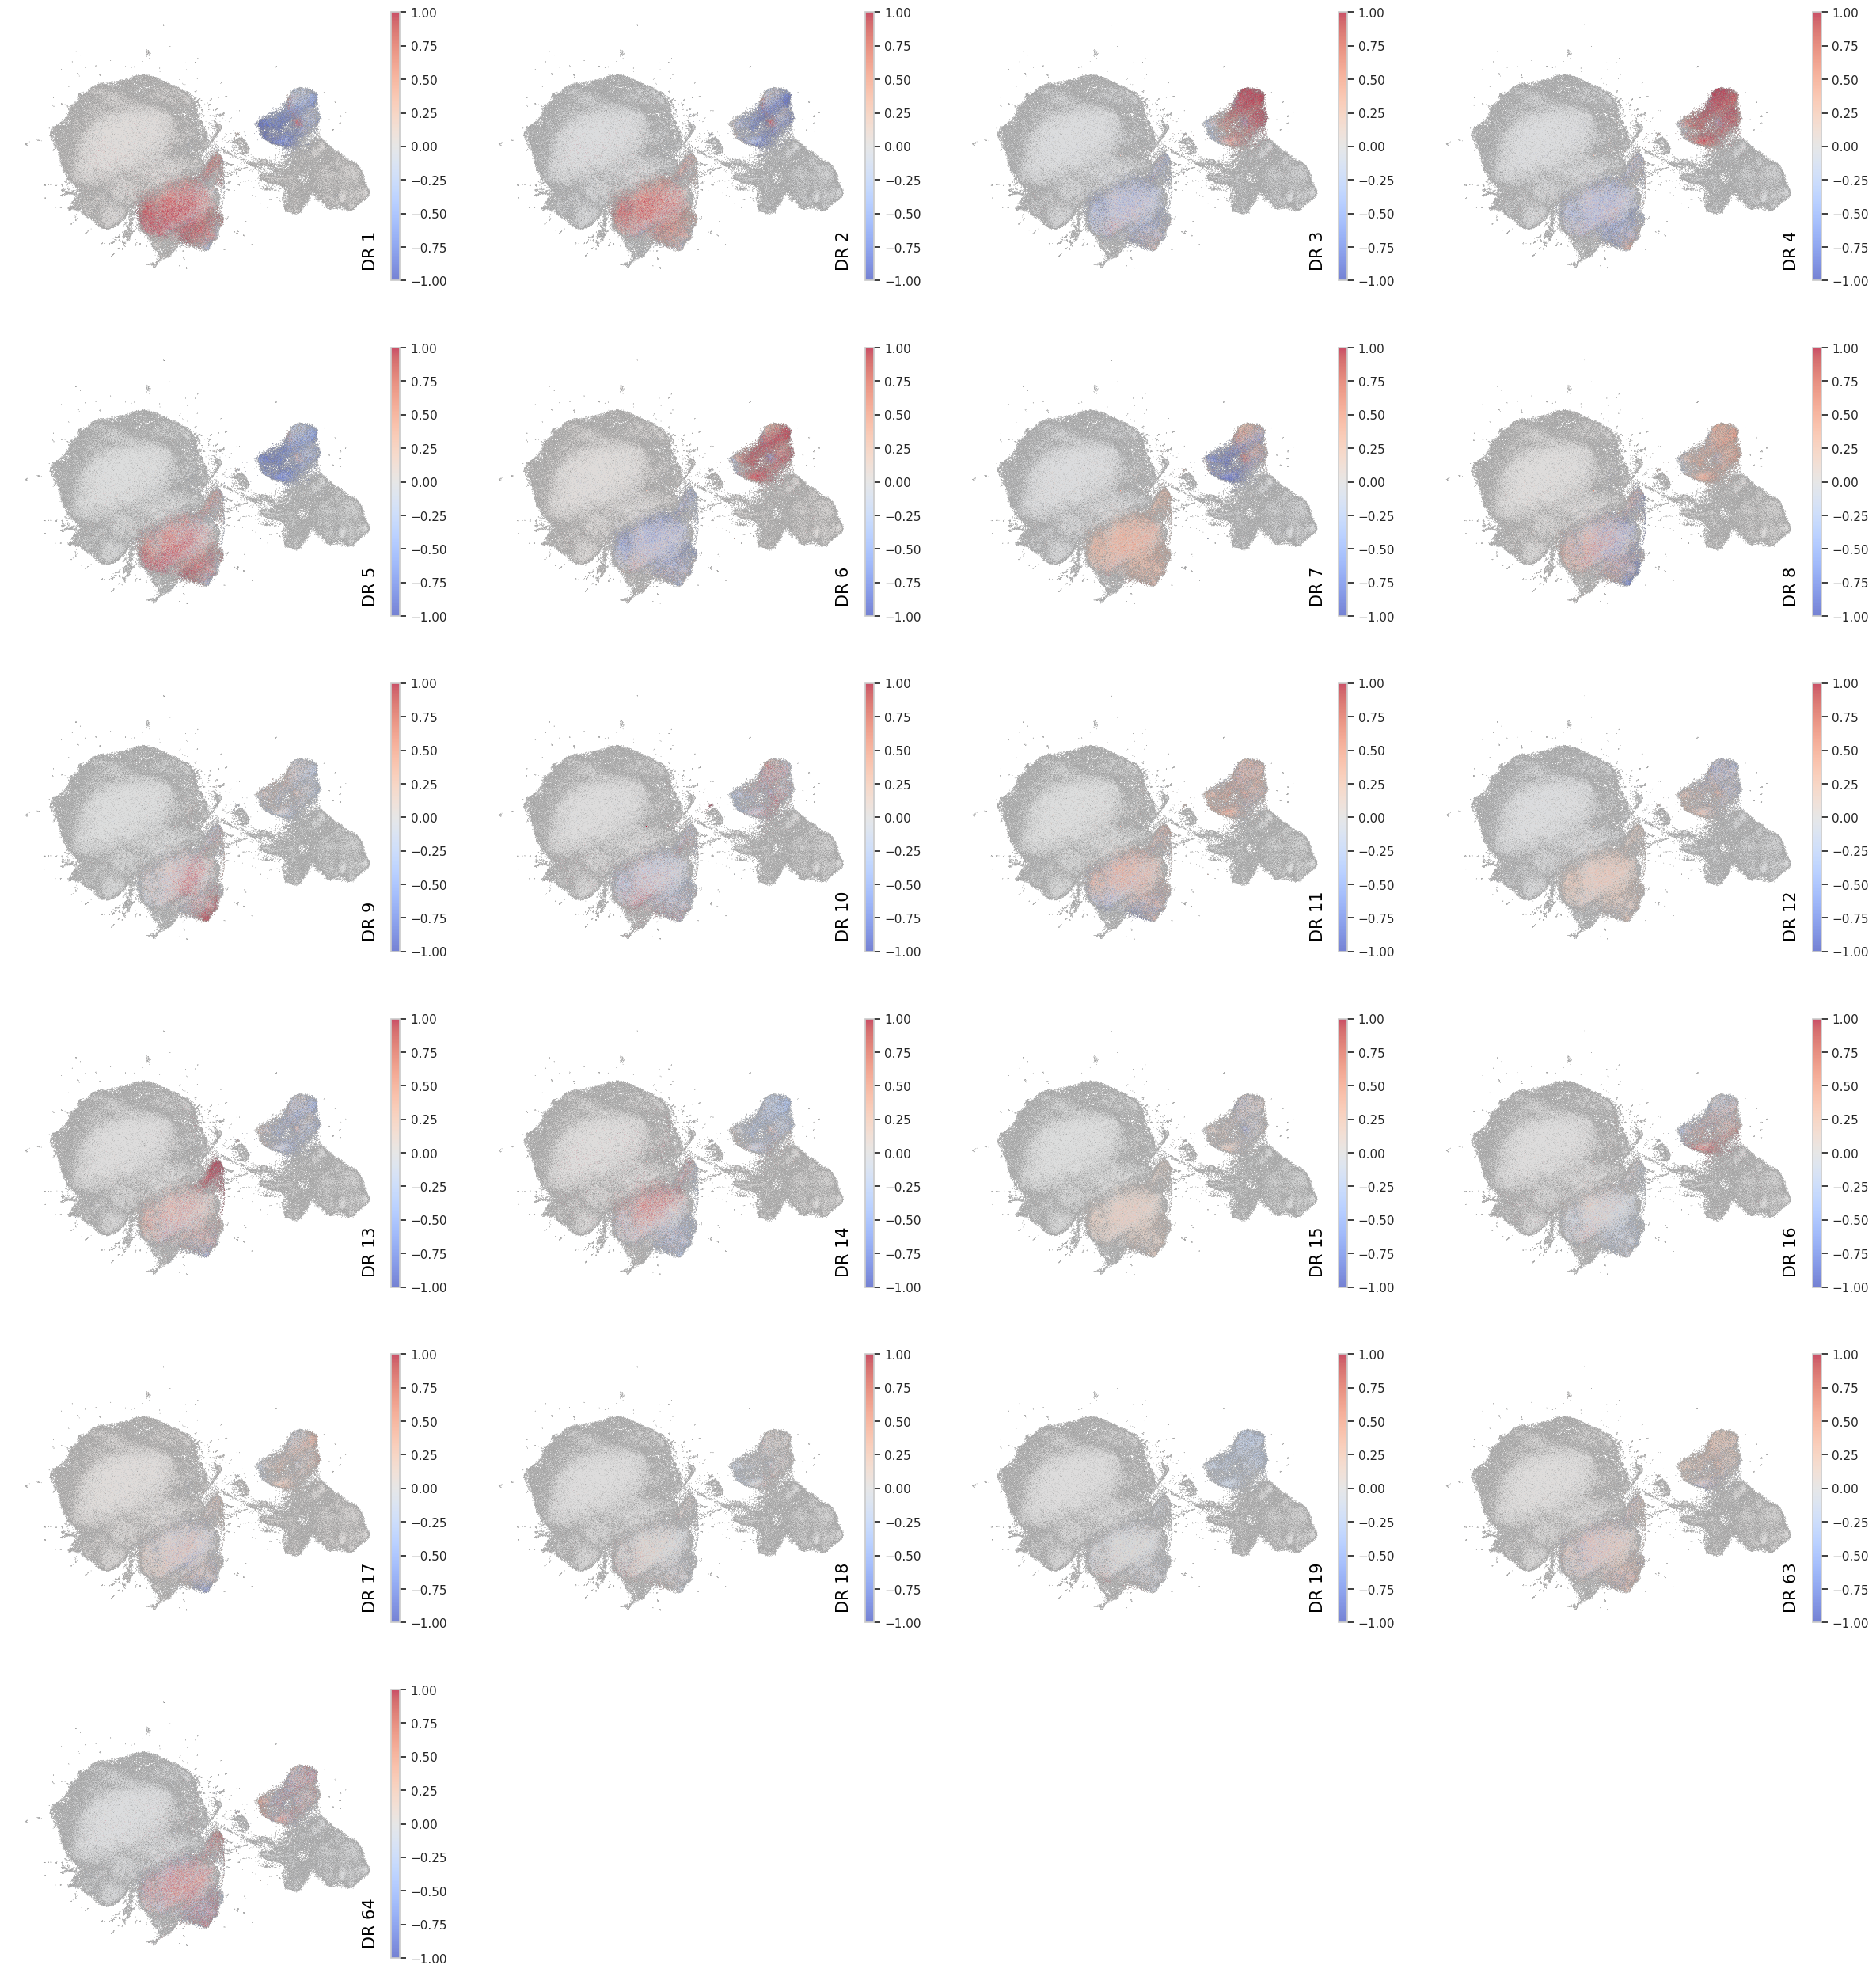

In [282]:
drvi.utils.pl.plot_latent_dims_in_umap(
    embed, 
    show = False,
    add_outline=True,
    na_color='white',
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    outline_color=['black', 'white'],
    outline_width = [0.2, 0.025],
)
plt.savefig('./fig4/umap_drvi_latents.pdf', dpi = 300, bbox_inches='tight')

In [60]:
traverse_adata = drvi.utils.tl.traverse_latent(model, embed, n_samples=20, max_noise_std=0.0)
drvi.utils.tl.calculate_differential_vars(traverse_adata)

/home/icb/daniele.lucarelli/miniconda3/envs/notebooks/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


traversing latent ...
Input latent shape: control: (25600, 64), effect: (25600, 64)
Output mean param shape: control: (25600, 2335), effect: (25600, 2335)
Finding differential variables per latent dimension ...


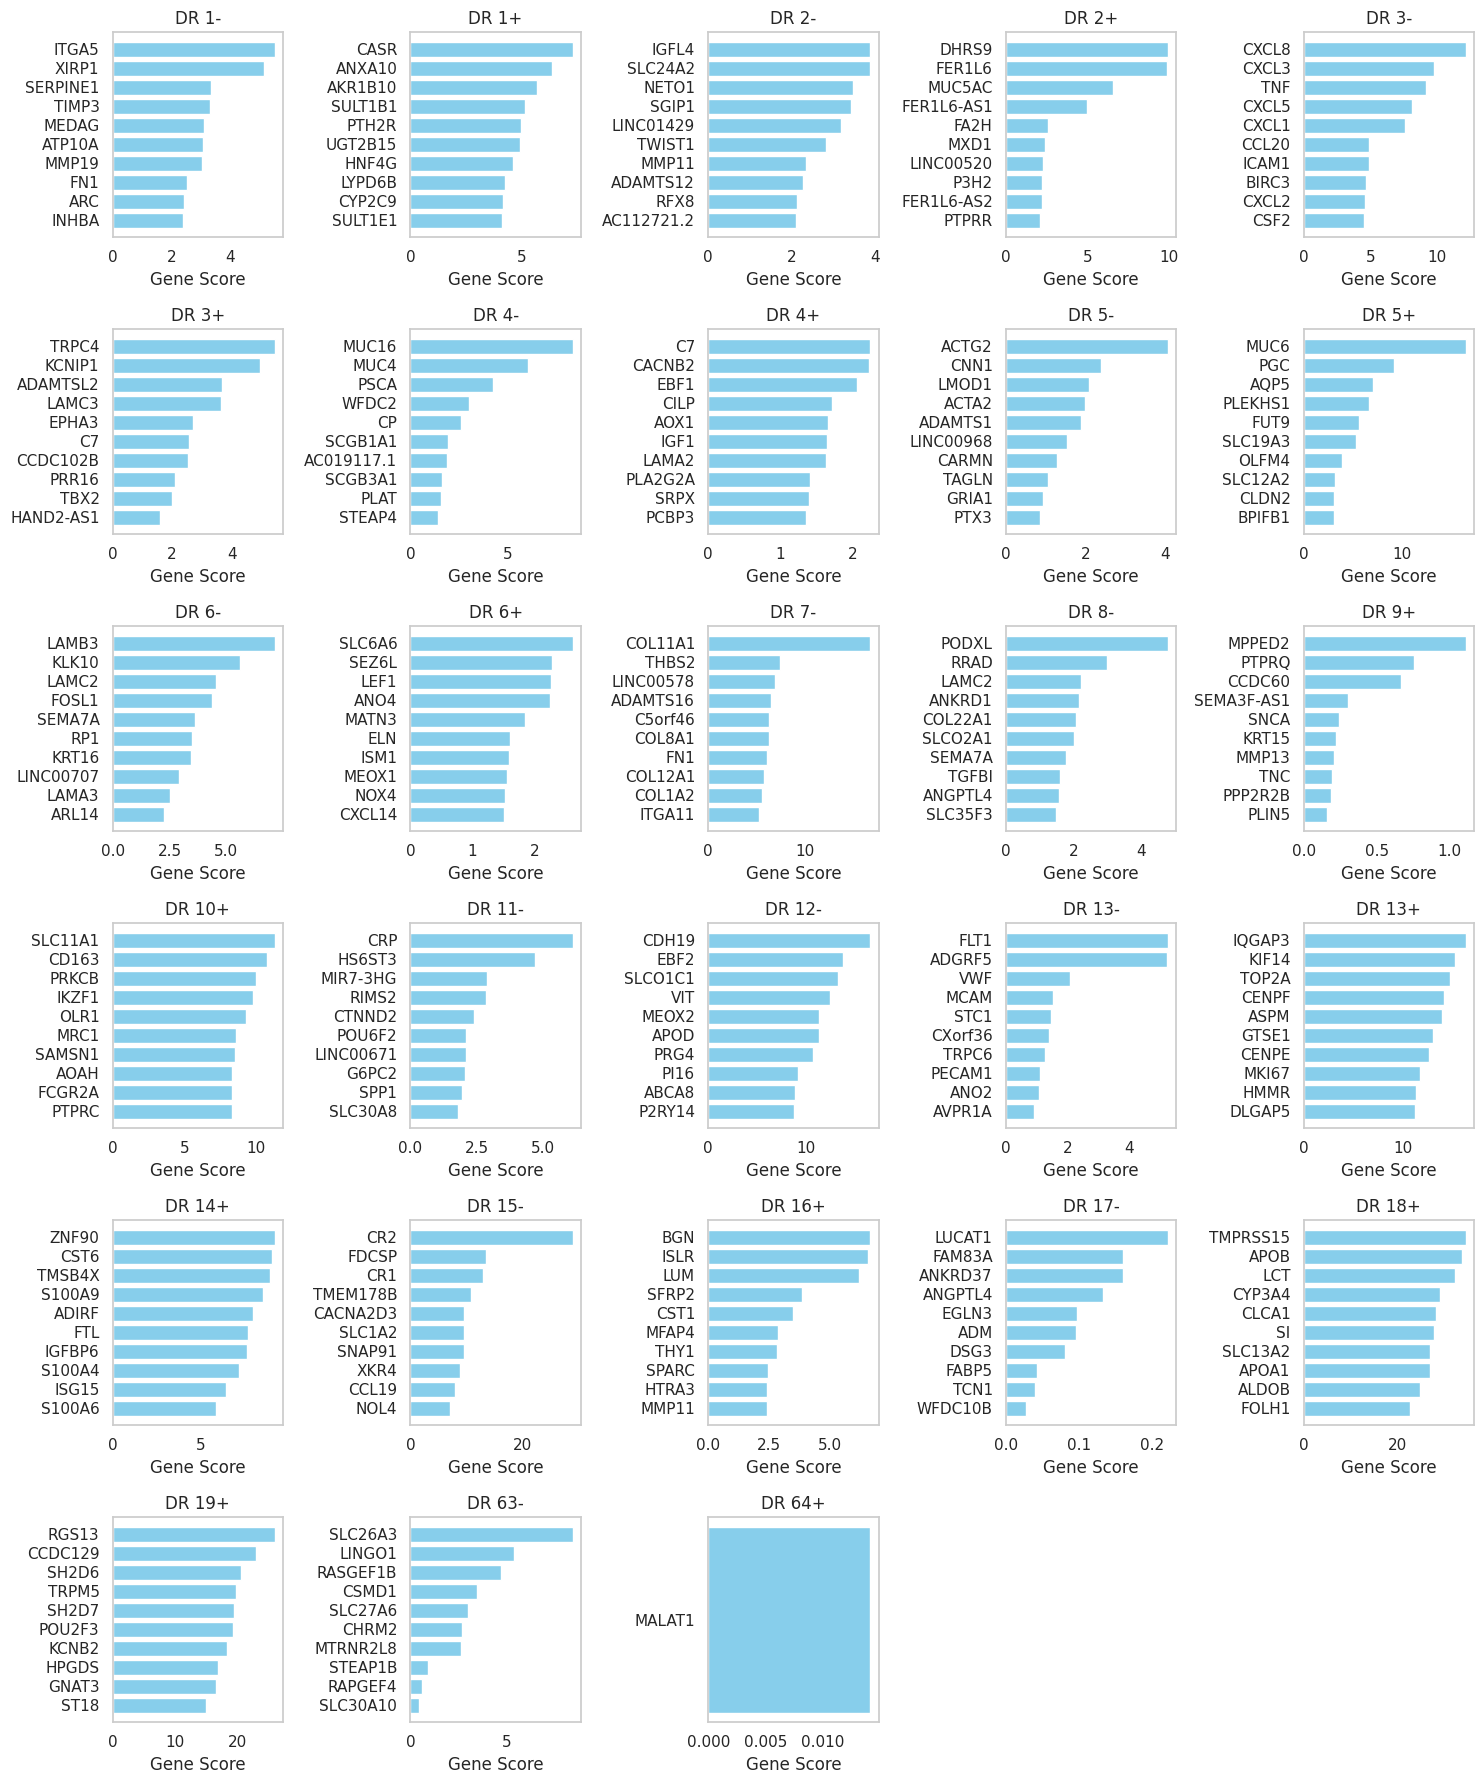

In [283]:
drvi.utils.pl.show_top_differential_vars(traverse_adata, key="combined_score", score_threshold=0.0, show = False)
plt.savefig('./fig4/barplots_drvi_explainability.pdf', dpi = 300, bbox_inches='tight')

## interpret

In [78]:
dimensions_interpretability = drvi.utils.tools.iterate_on_top_differential_vars(
    traverse_adata, key="combined_score", score_threshold=0.0
)

In [94]:
import gseapy as gp
from gseapy import barplot, dotplot


In [113]:
libraries = gp.get_library_name()

In [385]:
genes_list=[]
for dim_title, gene_scores in dimensions_interpretability:
    if dim_title in ['DR 3+','DR 4+', 'DR 11+', 'DR 15+', 'DR 16+', 'DR 17+']:
        gene_scores = gene_scores[gene_scores > gene_scores.max() / 10]
        relevant_genes = gene_scores.index.to_list()[:150]
        genes_list.extend(relevant_genes)


/home/icb/daniele.lucarelli/miniconda3/envs/notebooks/lib/python3.12/site-packages/gseapy/plot.py:753: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda _x: _x.sort_values(by=self.colname).tail(self.n_terms))


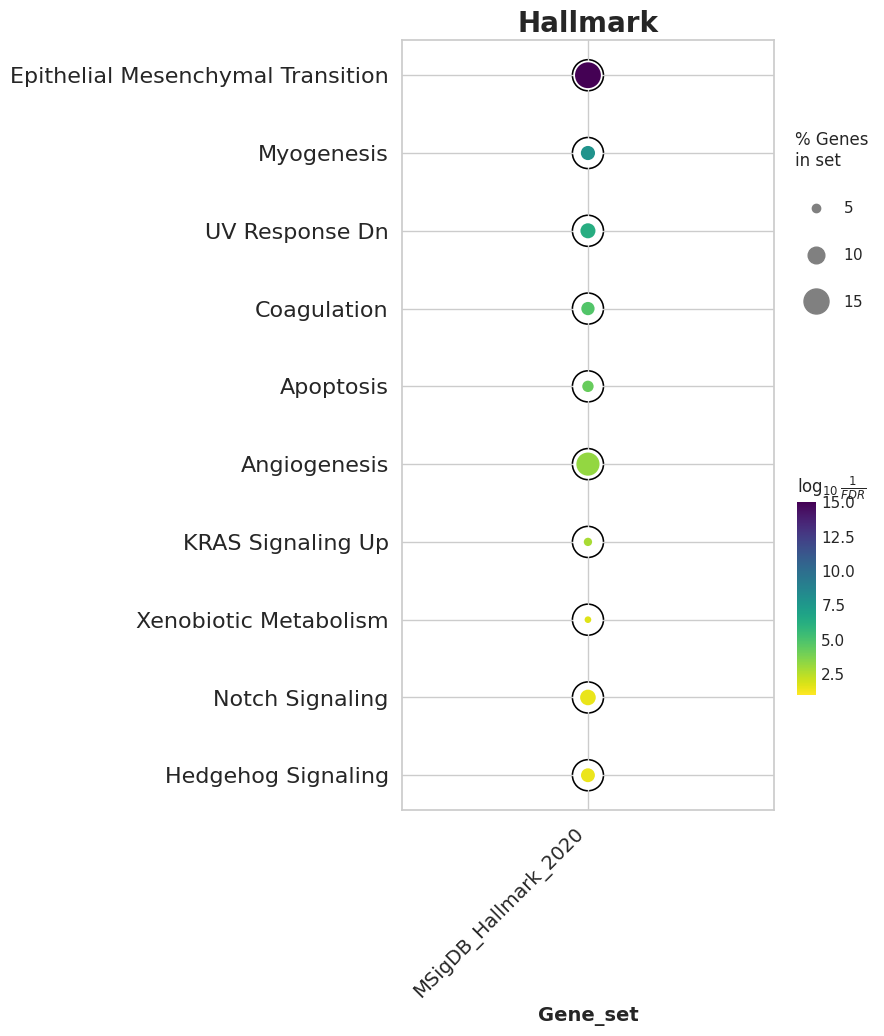

In [386]:
enr = gp.enrichr(gene_list=genes_list,
        gene_sets=['MSigDB_Hallmark_2020',],#'Reactome_Pathways_2024','TF_Perturbations_Followed_by_Expression'],
         organism='human', 
         outdir=None, 
        )
dotplot(enr.results,
      column="Adjusted P-value",
      x='Gene_set',
      size=20,
      cutoff=.2,
      top_term=10,
      figsize=(6,10),
      title = "Hallmark",
      xticklabels_rot=45, 
      show_ring=True, 
      marker='o',
     )
plt.savefig('./fig4/gsea_enr.pdf', dpi = 300, bbox_inches='tight')

In [343]:
angio_genes= enr.results[enr.results.Term == 'Angiogenesis'].Genes.tolist()[0].split(';')
emt_genes= enr.results[enr.results.Term == 'Epithelial Mesenchymal Transition'].Genes.tolist()[0].split(';')

In [348]:
adata_malignant.obsm['X_umap'] = embed.obsm['X_umap']

# Compositional plots

In [ ]:
#add compositional plot of malignant & tme cells with level 3 annotation
#show boxplot of radio vs no radio of all tme cells at level 4 annnotation
#store plots 

# CELL-CELL communication

In [ ]:
# add cell cell communication plot between malignant and tme cells only radio therapy